In [33]:
from joblib import dump

In [1]:
import os
import pickle
import tensorflow as tf
import numpy as np
from tqdm.notebook import tqdm
from tensorflow.keras.applications.vgg16 import VGG16,preprocess_input
from tensorflow.keras.preprocessing.image import load_img,img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical,plot_model
from tensorflow.keras.layers import Input,Dense,LSTM,Embedding,Dropout,add

2025-01-05 05:40:23.962061: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736055624.077404     904 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736055624.112113     904 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-05 05:40:24.388828: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
###EXtract Image Featurs
#load VGG16 model
model=VGG16()
#restructure Model
model=Model(inputs=model.inputs,outputs=model.layers[-2].output)
#summarize
print(model.summary())

I0000 00:00:1736055630.263977     904 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2248 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5


 37437440/553467096 ━━━━━━━━━━━━━━━━━━━━ 2:22 0us/step

In [ ]:
#Extract Features from Image
features={}
directory='./Images'

'''for img_name in tqdm(os.listdir(directory)):
    #load image form file
    
    img_path=directory+'/'+img_name
    image=load_img(img_path,target_size=(224,224))
    #image.show()
    
    
    #convert image to numpy array
    image=img_to_array(image)
    #reshape data for model
    image=image.reshape((1,image.shape[0],image.shape[1], image.shape[2]))
    #preprocess image for VGG16
    image=preprocess_input(image)
    #extract features
    feature=model.predict(image,verbose=0)
    #get image ID
    image_id=img_name.split('.')[0]
    
    
    features[image_id]=feature
    
    '''

In [ ]:

#store features in pickle
'''data = features
# Save the data to a pickle file
with open('features.pkl', 'wb') as f:  # 'wb' ensures binary write mode
    pickle.dump(data, f, protocol=pickle.HIGHEST_PROTOCOL)  # Use highest protocol for compatibility'''

In [38]:
#load features from pickle
try:
    with open('./vars/features.pkl', 'rb') as f:
        features = pickle.load(f)
        print("Features loaded successfully.")
except EOFError:
    print("The file is empty or corrupted. Please regenerate the pickle file.")

Features loaded successfully.


In [39]:
#load captions data
with open('./vars/captions.txt','r') as f:
    next(f)
    captions_doc=f.read()
    

In [40]:
#captions_doc
#features

In [41]:
#create mapping of image to captions
mapping={}
#process lines
for line in tqdm(captions_doc.split('\n')):
    #split the line by comma
    tokens=line.split(',')
    if len(line)<2:
        continue
    image_id,caption=tokens[0],tokens[1:]
    #remove extension from image id
    image_id=image_id.split('.')[0]
    #convert caption list to string
    caption=" ".join(caption)
    #create list if needed
    if image_id not in mapping:
        mapping[image_id]=[]
    mapping[image_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

In [42]:
len(mapping)

8091

In [43]:
#Preprocess Text Data
def clean(mapping):
    for key,captions in mapping.items():
        for i in range(len(captions)):
            #take one caption at a time
            caption=captions[i]
            #preprocessing steps
            caption=caption.lower()#convert to lower case
            caption=caption.replace('[^A-Za-z]','')#removing special characters and digits
            caption=caption.replace(r'\s+',' ')#removing multiple spaces
            
            #add start and end tags
            caption='startseq '+" ".join([word for word in caption.split() if len(word)>1])+' endseq'
            captions[i]=caption
            
        

In [44]:
#before preprocess 
mapping['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [45]:
#preprocess the text
clean(mapping)

In [46]:
#after Preprocess
mapping['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

In [47]:
dump(mapping,"./vars/Mapping.joblib")

['Mapping.joblib']

In [48]:
all_captions=[]
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [49]:
len(all_captions)

40455

In [50]:
all_captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

In [64]:
#tokenize the text
tokenizer=Tokenizer()
tokenizer.fit_on_texts(all_captions)
dump(tokenizer,'./vars/Tokenizer.joblib')
vocab_size=len(tokenizer.word_index)+1
vocab_size

8485

In [52]:
#get max length of the caption available
max_len=max(len(caption.split()) for caption in all_captions)
max_len

35

In [53]:
#Train Test Split
image_ids=list(mapping.keys())
split=int(len(image_ids)*0.90)
train=image_ids[:split]
test=image_ids[split:]

In [54]:
# create data generator to get data in batch (avoids session crash)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length, padding='post')[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], 	num_classes=vocab_size)[0]
                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield {'image': X1, 'text': X2}, y
                X1, X2, y = list(), list(), list()
                n = 0

In [55]:
# encoder model
# image feature layers
'''inputs1 = Input(shape=(4096,), name="image")
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# sequence feature layers
inputs2 = Input(shape=(max_len,), name="text")
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# plot the model
plot_model(model, show_shapes=True)'''

'inputs1 = Input(shape=(4096,), name="image")\nfe1 = Dropout(0.4)(inputs1)\nfe2 = Dense(256, activation=\'relu\')(fe1)\n# sequence feature layers\ninputs2 = Input(shape=(max_len,), name="text")\nse1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)\nse2 = Dropout(0.4)(se1)\nse3 = LSTM(256)(se2)\n\n# decoder model\ndecoder1 = add([fe2, se3])\ndecoder2 = Dense(256, activation=\'relu\')(decoder1)\noutputs = Dense(vocab_size, activation=\'softmax\')(decoder2)\n\nmodel = Model(inputs=[inputs1, inputs2], outputs=outputs)\nmodel.compile(loss=\'categorical_crossentropy\', optimizer=\'adam\')\n\n# plot the model\nplot_model(model, show_shapes=True)'

In [56]:
from tensorflow.keras.models import load_model
epochs = 20
batch_size = 32
steps = len(train) // batch_size
modelt=load_model("./model/best_model_70_epochs.keras")
for i in range(epochs):
    # create data generator
    generator = data_generator(train, mapping, features, tokenizer, max_len, vocab_size, batch_size)
    print("epoch : %d" %i)
    # fit for one epoch
    modelt.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

'epochs = 20\nbatch_size = 32\nsteps = len(train) // batch_size\n\nfor i in range(epochs):\n    # create data generator\n    generator = data_generator(train, mapping, features, tokenizer, max_len, vocab_size, batch_size)\n    print("epoch : %d" %i)\n    # fit for one epoch\n    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)'

In [57]:

#os.makedirs("model", exist_ok=True)
'''model.save("best_model_70_epochs.keras")'''


'model.save("best_model_70_epochs.keras")'

In [58]:
#generate Captions for Image
def idx_to_word(integer,tokenizer):
    for word,index in tokenizer.word_index.items():
        if index == integer:
            return word
    return none
    

In [59]:
#generate caption for an image
def predict_caption(model,image,tokenizer,max_length):
    #add start tag for generation
    in_text='startseq'
    #iterate over maxlength of sequence
    for i in range(max_length):
        #incode input sequence
        sequence=tokenizer.texts_to_sequences([in_text])[0]
        #pad the sequence
        sequence=pad_sequences([sequence],max_length)
        #predict next word
        yhat=model.predict([image,sequence],verbose=0)
        #convert index with high probability
        yhat=np.argmax(yhat)
        #convert index to word
        word=idx_to_word(yhat,tokenizer)
        #stop if word not found
        if word is None:
            break
        #append word as input for generation next word
        in_text +=" "+word
        #stop if we reach end tag
        if word =='endseq':
            break
    return in_text
    

In [60]:

'''from nltk.translate.bleu_score import corpus_bleu
#validate with test data
actual,predicted=[],[]
for key in tqdm(test):
    #get actudal caption
    captions=mapping[key]
    #predict the caption for image
    y_pred=predict_caption(model,features[key],tokenizer,max_len)
    #split into words
    actual_captions=[caption.split() for caption in captions]
    y_pred=y_pred.split()
    actual.append(actual_captions)
    predicted.append(y_pred)
#Calculate BLEU Score
print("Corpus will be started")
print("BLEU-1: %f" %corpus_bleu(actual,predicted,weights=(1.0,0,0,0)))
print("BLEU-1: %f" %corpus_bleu(actual,predicted,weights=(0.5,0.5,0,0)))'''

'from nltk.translate.bleu_score import corpus_bleu\n#validate with test data\nactual,predicted=[],[]\nfor key in tqdm(test):\n    #get actudal caption\n    captions=mapping[key]\n    #predict the caption for image\n    y_pred=predict_caption(model,features[key],tokenizer,max_len)\n    #split into words\n    actual_captions=[caption.split() for caption in captions]\n    y_pred=y_pred.split()\n    actual.append(actual_captions)\n    predicted.append(y_pred)\n#Calculate BLEU Score\nprint("Corpus will be started")\nprint("BLEU-1: %f" %corpus_bleu(actual,predicted,weights=(1.0,0,0,0)))\nprint("BLEU-1: %f" %corpus_bleu(actual,predicted,weights=(0.5,0.5,0,0)))'

In [61]:
 
model3=tf.keras.models.load_model("best_model_70_epochs.keras")

In [62]:
##Visualize results\
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name,model):
    #load Image
    #image_name="1002674143_1b742ab4b8.jpg"
    image_id=image_name.split('.')[0]
    image_path=os.path.join("Images",image_name)
    image=Image.open(image_path)
    
    captions=mapping[image_id]
    print("---------------------------Original Caption--------------------------")
    for caption in captions:
        print(caption)
    
    #predict the caption
    y_pred=predict_caption(model,features[image_id],tokenizer,max_len)
    
    print("--------------------------Predicted Caption----------------")
    print(y_pred)
    plt.imshow(image)

---------------------------Original Caption--------------------------
startseq three girls do back flips and cartwheels in the surf endseq
startseq three girls do handstands at the beach endseq
startseq three girls doing back flips on the beach endseq
startseq three little girls cartwheel in the ocean endseq
startseq three young girls playing on the beach endseq
--------------------------Predicted Caption----------------
startseq two girls do handstands at the beach endseq


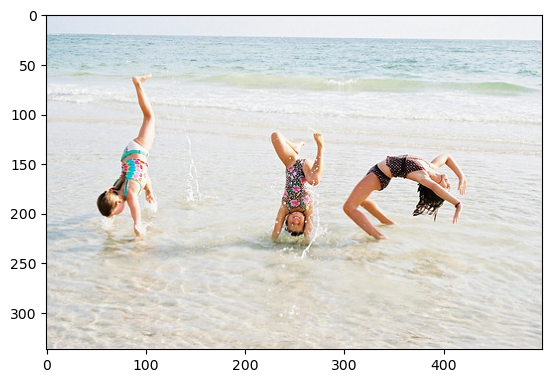

In [63]:
generate_caption("3747543364_bf5b548527.jpg",model3)